In [508]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
import pandas as pd
import os 
import matplotlib.pyplot as plt
import math
import random
import torch.nn.functional as F

In [509]:
words=open('names.txt').read().splitlines()
chars=sorted(list(set(''.join(words))))
s_to_i={s:i+1 for i,s in enumerate(chars) }
s_to_i['.']=0
i_to_s={i:s for s,i in s_to_i.items()}
vocab_size=len(i_to_s)
s_to_i

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [707]:
def build_dataset(words):
    context_length=3
    x,y=[],[]
    for w in words:
        # print(w)
        context=[0]*context_length
        for ch in w+'.':
            idx=s_to_i[ch]
            x.append(context)
            y.append(idx)
            # print(''.join(i_to_s[i] for i in context),'--->',i_to_s[idx])
            context=context[1:]+[idx]
    x=torch.tensor(x)
    y=torch.tensor(y)
    print(x.shape,y.shape)
    return x,y


random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

x_train,y_train=build_dataset(words[:n1])
x_val,y_val=build_dataset(words[n1:n2])
x_test,y_test=build_dataset(words[n2:])



torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [741]:
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weights=torch.randn((fan_in,fan_out),generator=g)/(fan_in**0.5)
        self.bias=torch.zeros(fan_out) if bias else None 
        
    def __call__(self,x):
        self.out=x @ self.weights 
        if self.bias is not None:
            self.out+=self.bias
        return  self.out
        
    def parameters(self):
        return [self.weights]+ ([] if self.bias is None else [self.bias])

class BactchNorm1d:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training=True
        # paramameters for scale and shift
        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim)
        # buffers
        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)

    def __call__(self,x):
        if self.training is True:
            xmean=x.mean(0,keepdims=True)
            x_var=x.var(0,keepdims=True)
        else:
            xmean=self.running_mean
            xvar=self.running_var
        x_norm=(x-xmean)/torch.sqrt(x_var+self.eps)
        self.out=self.gamma*x_norm+self.beta
        if self.training is True:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var=(1-self.momentum)+self.running_var+self.momentum*x_var
            
            
        return self.out

    def parameters(self):
        return [self.gamma,self.beta]

class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out
    def parameters(self):
        return []


            
# actual pytorch doesnt have self.out  but here we are doing that to keep access internal activtations 


In [827]:
# hyperparameters 
batch_size=64
emb_space=10
context_length=3
x_view=x_train.shape[1]*emb_space
h_units=100
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,emb_space),generator=g)
lossi=[]
steps=[]
lri=[]
lrex=[]
ud=[]


In [828]:
layers=[
    Linear(emb_space*context_length,h_units),Tanh(),
    Linear(h_units,h_units),Tanh(),
    Linear(h_units,h_units),Tanh(),
    Linear(h_units,h_units),Tanh(),
    Linear(h_units,h_units),Tanh(),
    Linear(h_units,vocab_size),
]

with torch.no_grad():
    layers[-1].weights*=0.1
    # layers[-1].gamma*=0.1  # making last layer less confident 
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weights*=5/3

parameters=[C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad=True

print(sum(p.nelement() for p in parameters))

46497


In [829]:
max_steps=200000
for i in range(max_steps):
    #minibatch construct
    ix=torch.randint(0,x_train.shape[0],(batch_size,),generator=g) 
    #foward pass
    emb=C[x_train[ix]]
    x=emb.view(emb.shape[0],-1)
    for layer in layers:
        x=layer(x)
    loss=F.cross_entropy(x,y_train[ix])
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad=None
    loss.backward()
    
    lr=0.1 if i<100000 else 0.01
        
    for p in parameters:
            p.data+=-lr*p.grad

     # track stats
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    steps.append(i)
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std()/ p.data.std()).log10().item() for p in parameters])
    if i >1000:
        break
    # break

      0/ 200000 : 3.2962


layer 1 (      Tanh): mean -0.05, std 0.77, saturated:22.98%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated:11.75%
layer 5 (      Tanh): mean -0.01, std 0.73, saturated:12.84%
layer 7 (      Tanh): mean -0.05, std 0.72, saturated:10.27%
layer 9 (      Tanh): mean +0.02, std 0.71, saturated:9.92%


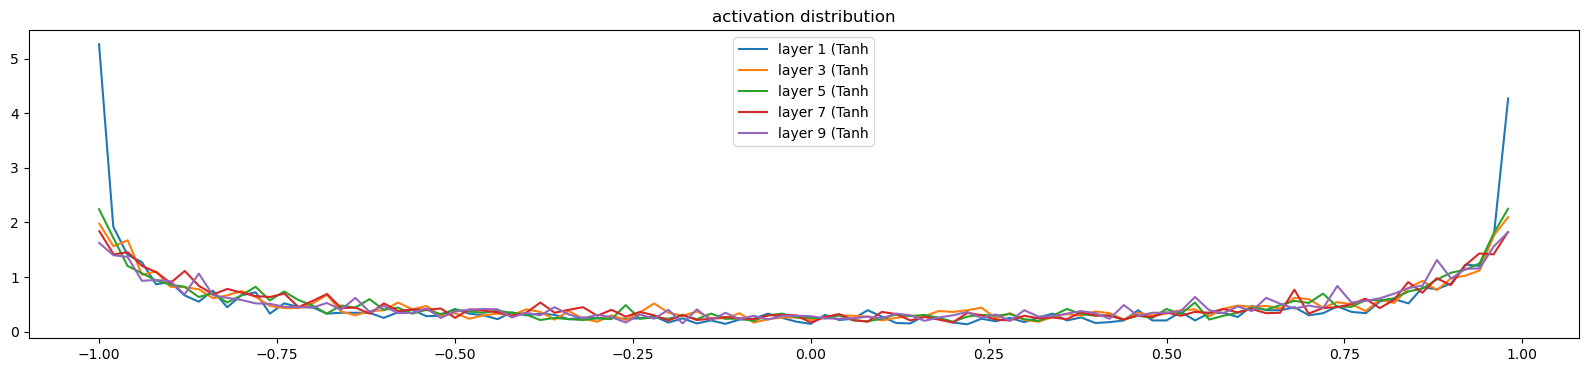

In [838]:
plt.figure(figsize=(20,4))
legends=[]
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t=layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated:%.2f%%' % (i,layer.__class__.__name__, t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution');
# thu  we get low saturation as we go deeper in the layers 

layer 0 (    Linear): mean -0.11, std 1.76
layer 2 (    Linear): mean -0.02, std 1.34
layer 4 (    Linear): mean +0.00, std 1.39
layer 6 (    Linear): mean -0.06, std 1.30
layer 8 (    Linear): mean +0.04, std 1.29


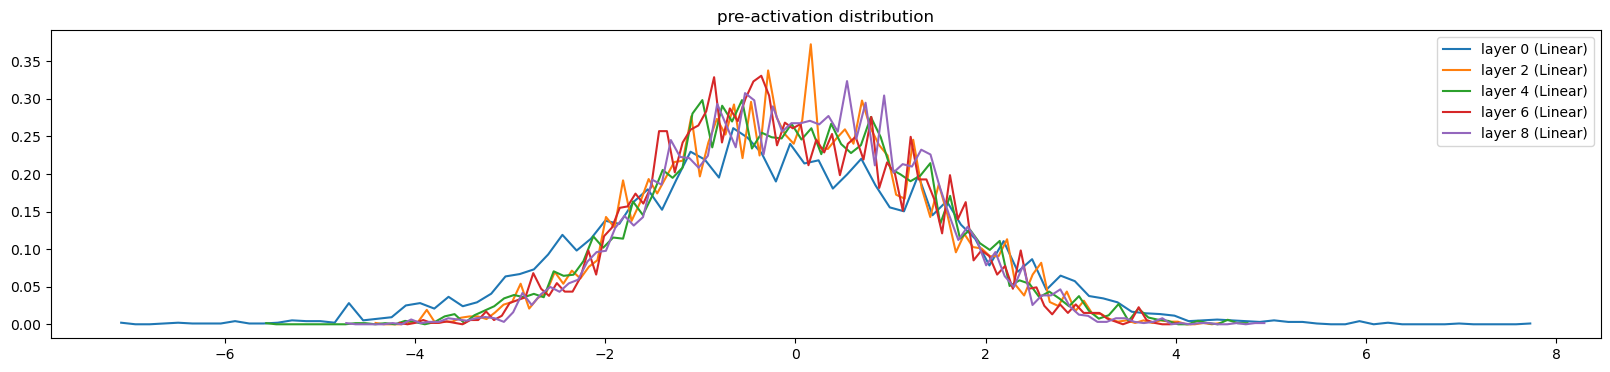

In [831]:
plt.figure(figsize=(20,4))
legends=[]
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer,Linear):
        t=layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f' % (i,layer.__class__.__name__, t.mean(),t.std()))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('pre-activation distribution');
# thus all pre activations have a simillar distribution indicating good training 

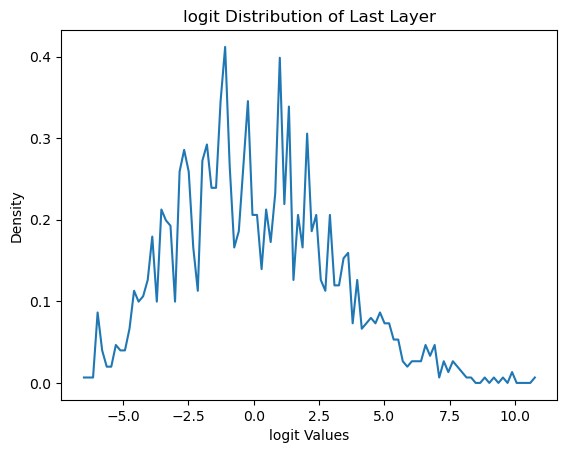

tensor(5.0540)


In [832]:
l = layers[-1].out  
hy, hx = torch.histogram(l, density=True)  # Compute histogram
bin_centers = (hx[:-1] + hx[1:]) 
# Plot the histogram
plt.plot(bin_centers.detach(), hy.detach())
plt.xlabel('logit Values')
plt.ylabel('Density')
plt.title('logit Distribution of Last Layer')
plt.show()
print(bin_centers.detach().std())


saturation%:58.375


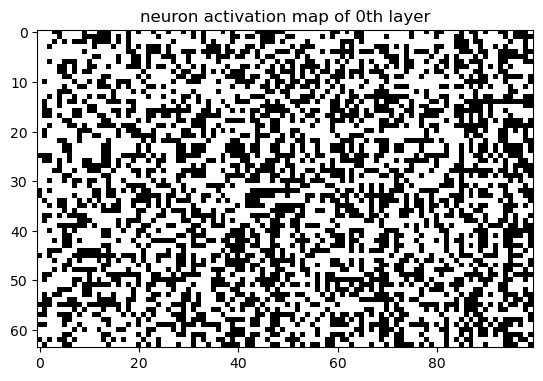

saturation%:22.984375


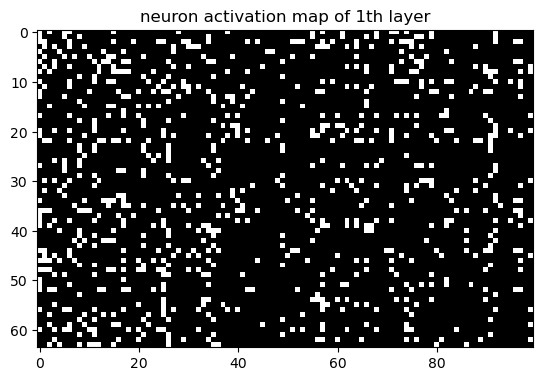

saturation%:48.875


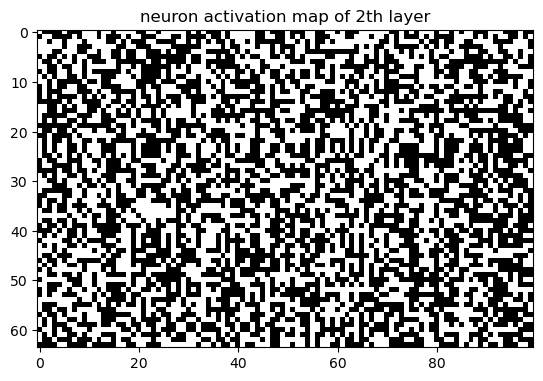

saturation%:11.75


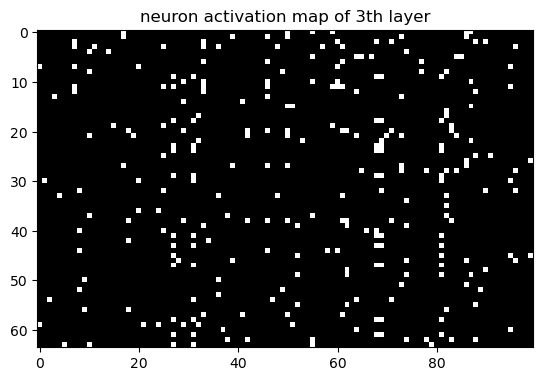

saturation%:49.921875


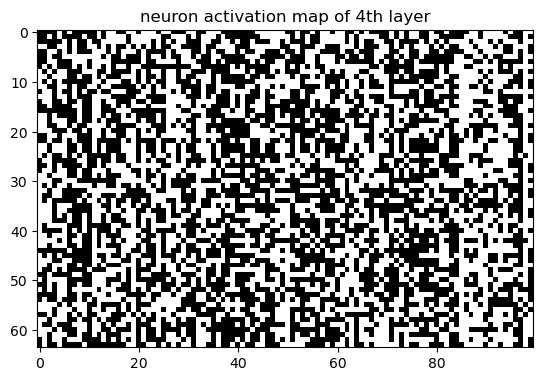

saturation%:12.84375


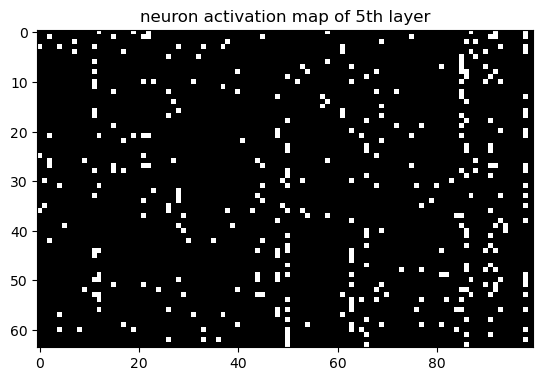

saturation%:49.5


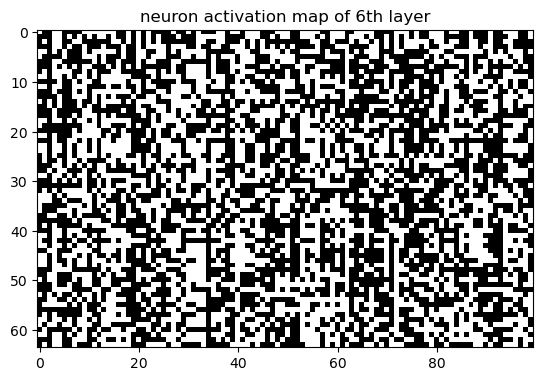

saturation%:10.265625


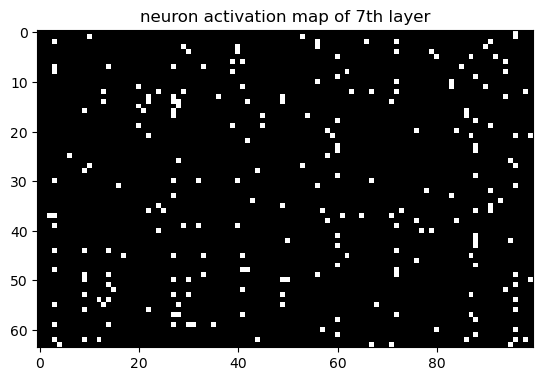

saturation%:47.78125


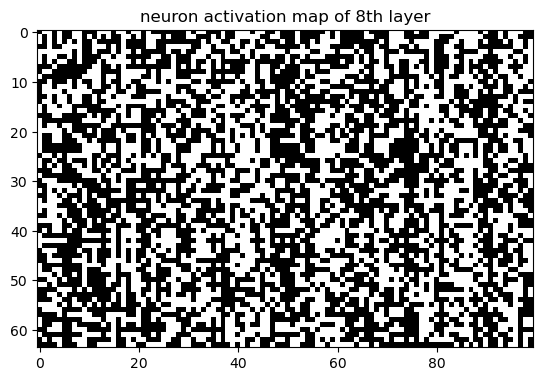

saturation%:9.921875


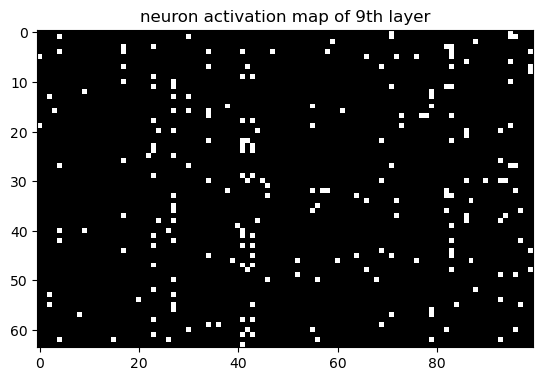

saturation%:52.48843002319336


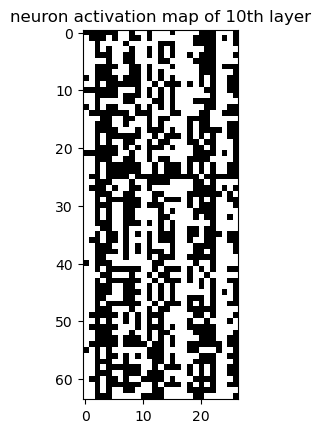

In [833]:
for i in range(11):
    l = layers[i].out
    if i!=10:
        plt.imshow(l.abs()>0.99, cmap='gray',interpolation='nearest');
    else:
        plt.imshow((l.abs()>0.99) , cmap='gray',interpolation='nearest');
        
    print(f'saturation%:{((l.abs()>0.97).float().mean()*100)}')
    plt.title(f'neuron activation map of {i}th layer')
    plt.show()
# as we can see there is a level low saturation in the last layer 

tensor(0.0002)


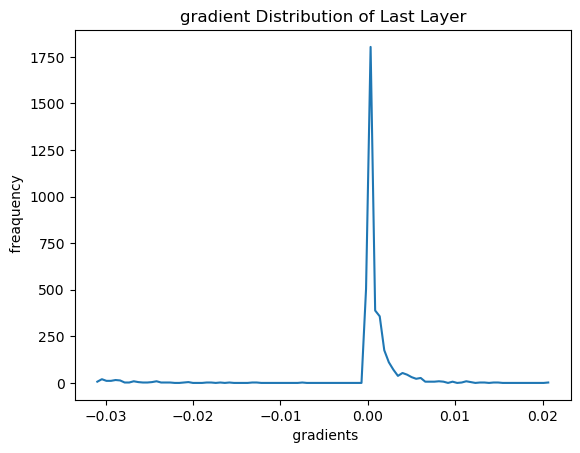

In [834]:
l=layers[-1].out.grad
print(torch.median(l))
hy, hx = torch.histogram(l, density=True)  # Compute histogram
bin_centers = (hx[:-1] + hx[1:]) 
# Plot the histogram
plt.plot(bin_centers.detach(),hy.detach());
plt.xlabel(' gradients')
plt.ylabel(' freaquency')
plt.title('gradient Distribution of Last Layer')
plt.show()
# the gradients arent saturated near zero 

layer 1 (      Tanh): mean +0.00, std 0.00
layer 3 (      Tanh): mean +0.00, std 0.00
layer 5 (      Tanh): mean +0.00, std 0.00
layer 7 (      Tanh): mean +0.00, std 0.00
layer 9 (      Tanh): mean +0.00, std 0.00


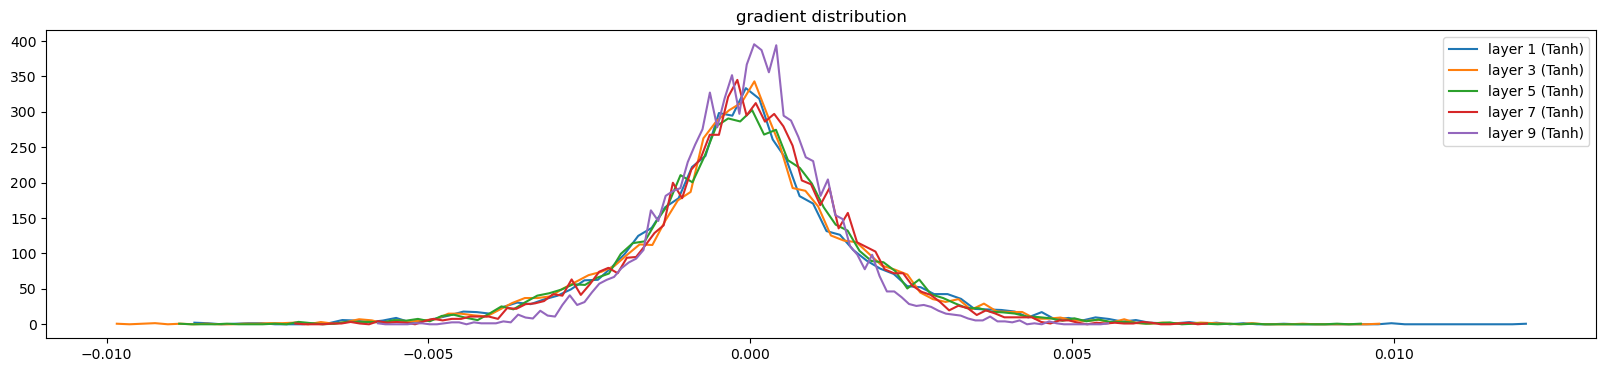

In [839]:
plt.figure(figsize=(20,4))
legends=[]
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t=layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f' % (i,layer.__class__.__name__, t.mean(),t.std()))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution');
# the gradient ddistributions are simillar thus there is no vanishing or exploding gradient problem 

weights (  (27, 10)): mean -0.000262, std 8.398715e-03, grad:data ratio 8.395725e-03
weights ( (30, 100)): mean -0.000201, std 7.994156e-03, grad:data ratio 2.559103e-02
weights ((100, 100)): mean -0.000061, std 6.830531e-03, grad:data ratio 4.077365e-02
weights ((100, 100)): mean +0.000068, std 5.918304e-03, grad:data ratio 3.493600e-02
weights ((100, 100)): mean -0.000061, std 5.330947e-03, grad:data ratio 3.160477e-02
weights ((100, 100)): mean +0.000024, std 4.120786e-03, grad:data ratio 2.440677e-02
weights ( (100, 27)): mean -0.000000, std 1.609762e-02, grad:data ratio 2.240148e-01


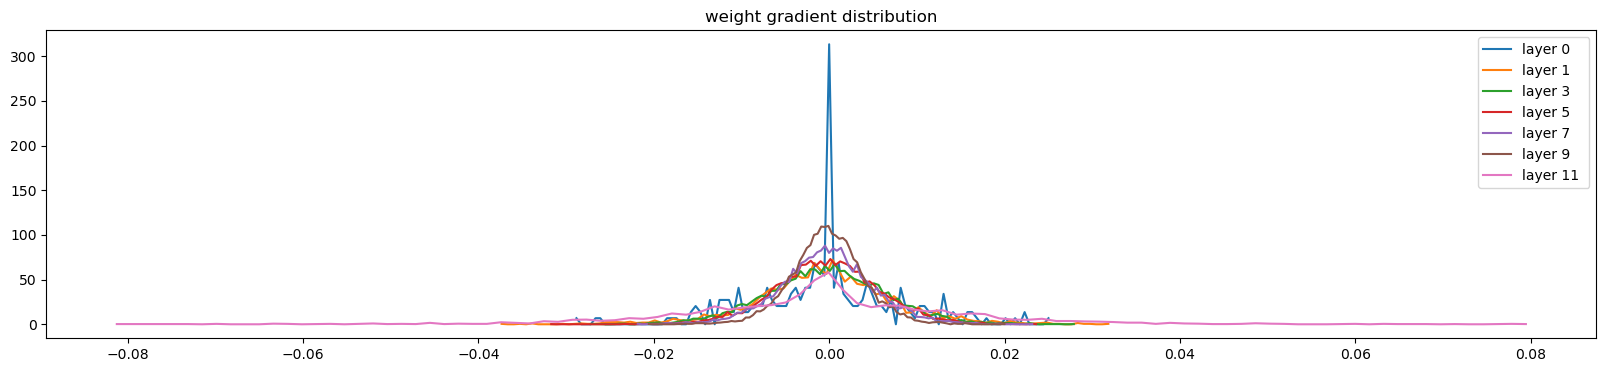

In [836]:
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    t=p.grad
    if p.ndim==2:
        print('weights (%10s): mean %+f, std %e, grad:data ratio %e' % (tuple(p.shape), t.mean(),t.std(),t.std()/p.std()))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ')
plt.legend(legends)
plt.title('weight gradient distribution');

# thus we can see that the weight distribution of the last layer that produces the logits has been squished 

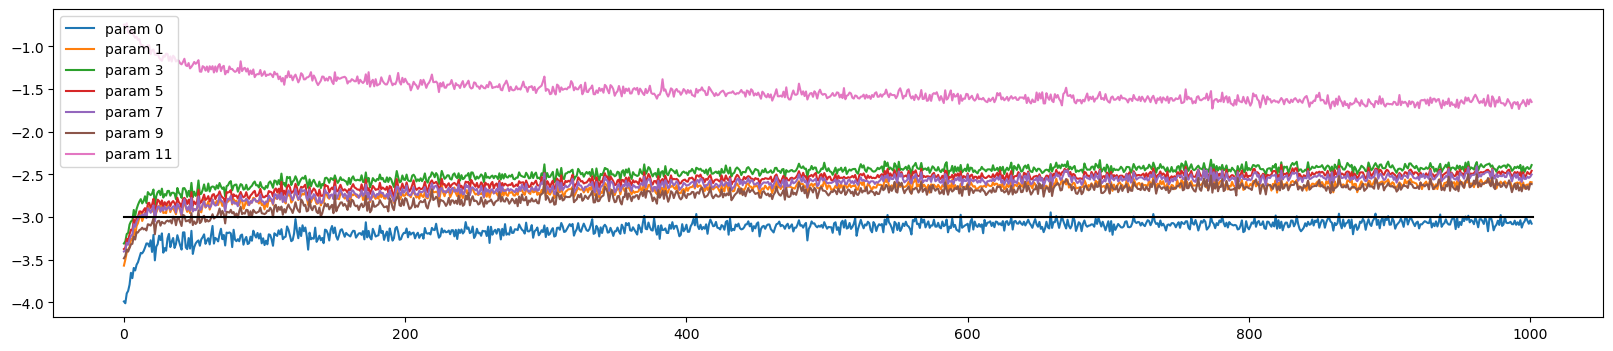

In [837]:
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0,len(ud)],[-3,-3],'k')
plt.legend(legends)

In [655]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train':(x_train,y_train),
        'val':(x_val,y_val),
        'test':(x_test,y_test)
        }[split]
    
    emb=C[x]
    x=emb.view(emb.shape[0],-1)
    for layer in layers:
        x=layer(x)
    loss=F.cross_entropy(x,y)
    
    print(split,loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 1.9388813972473145
val 2.0883162021636963
test 2.0935585498809814


In [671]:
print('after fixing last layer initialization: train 2.137437343597412 val 2.184746265411377 test 2.180730104446411')
print('after fixing last layer initialization: train 1.9388813972473145 val 2.0883162021636963 test 2.0935585498809814')

after fixing last layer initialization: train 2.137437343597412 val 2.184746265411377 test 2.180730104446411
after fixing last layer initialization: train 1.9388813972473145 val 2.0883162021636963 test 2.0935585498809814
